$$ \frac{d}{dx}\left(\nu\frac{du}{dx}\right) + \alpha\,u = f\qquad x\in\,(0,L)\qquad\alpha\in\mathbb{R}$$

cond(A) = 37819.58208477201
monolithic error = 1.8985187167875517e-12
{'type': 'dirichlet', 'value': -0.2955202066613396}
{'type': 'dirichlet', 'value': -0.29552020666133755}


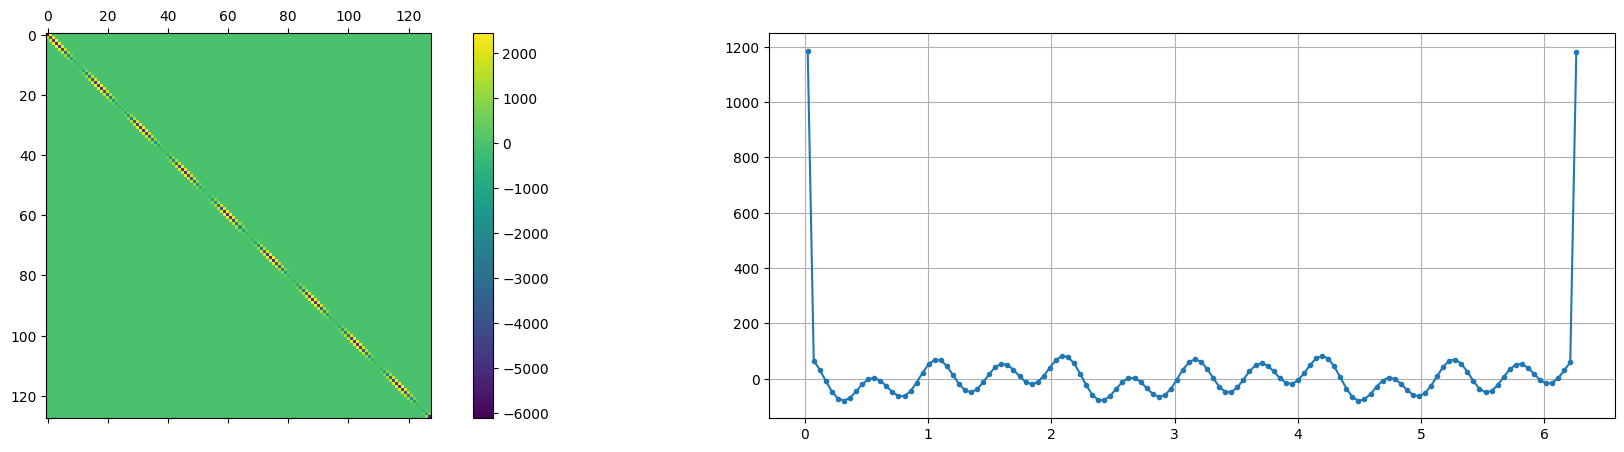

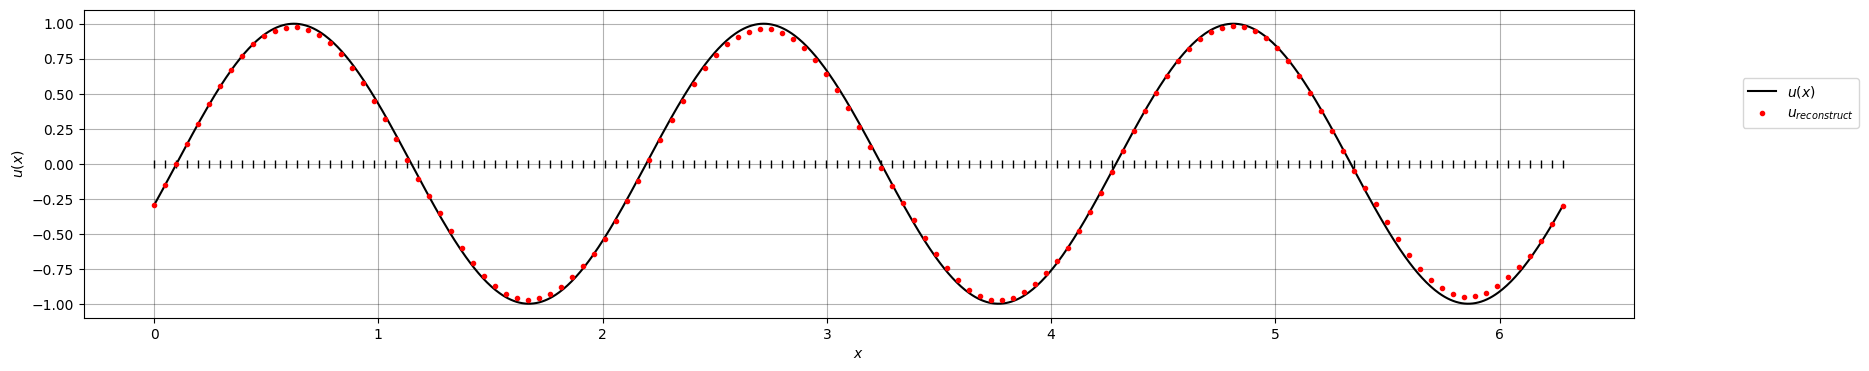

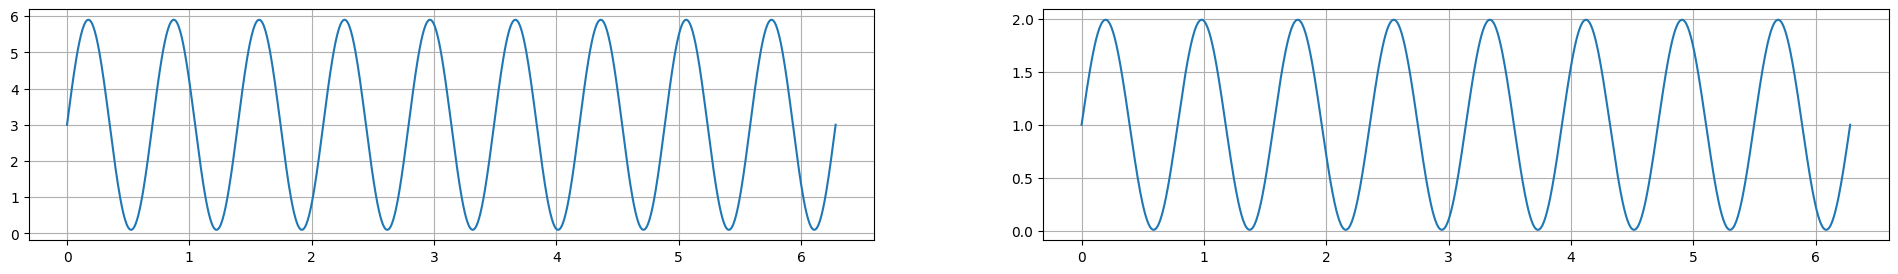

In [29]:
import scipy.sparse as sparse
import scipy.linalg as linalg
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import mylib

kwargs = {
    'A': 0,   #const
    'B': 1.0, #amplitude
    'C': 3.0, #frequency
    'D': 0.1, #shift
    
    'E': 3.0, #const
    'F': 2.9, #amplitude
    'G': 9.0, #frequency
    'H': 0.0  #shift
}

L = 2*np.pi
N = 128
dx = np.divide(L, N)
x = np.linspace(0, L, N+1)
xc = np.linspace(0.5*dx, L-0.5*dx, N)
xfine = np.linspace(0, L, 1000)

def alpha(x, kwargs):
    return 1.0 + 0.99*np.sin(8.0*x)

def sol(x, kwargs):
    return kwargs['A'] + kwargs['B']*np.sin(kwargs['C']*(x-kwargs['D']))

def dsoldx(x, kwargs):
    return kwargs['B']*kwargs['C']*np.cos(kwargs['C']*(x-kwargs['D']))

def d2soldx2(x, kwargs):
    return -kwargs['B']*np.square(kwargs['C'])*np.sin(kwargs['C']*(x-kwargs['D']))

def nu(x, kwargs):
    return kwargs['E'] + kwargs['F']*np.sin(kwargs['G']*(x-kwargs['H']))

def dnudx(x, kwargs):
    return kwargs['F']*kwargs['G']*np.cos(kwargs['G']*(x-kwargs['H']))
   
def f(x, kwargs):
    return alpha(x, kwargs)*sol(x, kwargs) + nu(x, kwargs)*d2soldx2(x, kwargs) + dnudx(x, kwargs)*dsoldx(x, kwargs)
    
leftBC = {
    'type':'dirichlet',
    'value':sol(0.0, kwargs)}

rightBC = {
    'type':'dirichlet', #'type':'neumann',
    'value':sol(L, kwargs)}

A_laplacian, fBC = mylib.fvm_laplacian_1D(nu, leftBC, rightBC, N, L, kwargs)
fTOT = f(xc, kwargs) + fBC
A = sparse.csc_matrix(A_laplacian + sparse.diags([alpha(xc, kwargs)], [0]))
u = sparse.linalg.spsolve(A, fTOT)
A = A.toarray()

print("cond(A) =", np.linalg.cond(A))
print(f"monolithic error = {np.linalg.norm(fTOT-np.dot(A,u))}")
print(leftBC)
print(rightBC)

fig0, axs = plt.subplots(1, 2, figsize=(24,5))
axsA = axs[0].matshow(A)
# axsf = axs[1].matshow(fTOT.reshape((N,1)))
axsf = axs[1].plot(xc, fTOT, '.-')
axs[1].grid()
fig0.colorbar(axsA, ax=axs[0])
# fig1.colorbar(axsf, ax=axs[1])
# axs[1].axis('off')
#plt.savefig('figures/matrix.pdf')

fig1, ax1 = plt.subplots(figsize=(20,4), dpi=100)
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$u(x)$')
ax1.plot(x, 0*x, '|', color='k', markersize=6.0)
# ax1.plot(xc, 0*xc, '.', color='k', markersize=2.0)
ax1.plot(xfine, sol(xfine, kwargs), '-k', label=r'$u(x)$')
ax1.plot(x, mylib.fvm_reconstruct_1D(u), '.r' , label=r'$u_{reconstruct}$', linewidth=0.8)
# ax1.plot(xc, u, '_y', label=r'$\frac{1}{|cell|}\int u\,dx$', markersize=10)
#ax.set_ylim(bottom=0.0)
#ax.set_xlim([-0.001,0.1])
ax1.legend(bbox_to_anchor=(1.15, 0.8))
ax1.grid(color='k', alpha=0.3)

fig2, ax2 = plt.subplots(1, 2, figsize=(24,3), dpi=100)
ax2[0].plot(xfine, nu(xfine, kwargs))
ax2[1].plot(xfine, alpha(xfine, kwargs))
ax2[0].grid()
ax2[1].grid()

plt.plot()
plt.show()